In [1]:
path_to_muograph = "../"
import sys
sys.path.insert(1, path_to_muograph)

![alternative text](../images/muograph_logo.png)


**<h1><center>POCA: tutorial</center></h1>**

The `EM` class is used to perform the **Expectation-Maximisation algorithm**, using both the **tracking information** provided by the `TrackingMST`and `Tracking_EM`. The latter computes the different geometries of interaction of muons with the volume voxels (`L`,`T`), as well as the weight matrix for each muon-voxel pair `W` needed for the maximisation step of the `EM` reconstruction algorithm.
The `POCA` class is instantiated at first, in order to obtain the PoCA locations to be used in `Tracking_EM`

### **I - Instanciation** 

First, let's instanciante the `TrackingMST` class. At first, we will consider a detector with perfect **spatial resolution** and **efficiency**:

In [2]:
csv_file = '../muograph/data/iron_barrel/barrel_and_cubes_scattering.csv'

from muograph.hits.hits import Hits

hits_in = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_in

GPU is not available. Using CPU


Collection of hits from 137,033 muons on 3 detector panels.

In [3]:
hits_out = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (3, 4, 5),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_out

Collection of hits from 137,033 muons on 3 detector panels.

In [4]:
from muograph.tracking.tracking import Tracking

tracks_in = Tracking(label="above", hits=hits_in)
tracks_out = Tracking(label="below", hits=hits_out)

tracks_in, tracks_out

(Collection of tracks from 137,033 muons 
  with perfect angular resolution.,
 Collection of tracks from 137,033 muons 
  with perfect angular resolution.)

In [5]:
output_dir = "../output_test/"
from muograph.tracking.tracking import TrackingMST
mst = TrackingMST(trackings=(tracks_in, tracks_out))
mst

Collection of tracks from 137,033 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

The `POCA` class takes the following **arguments**:


- `tracking (Optional[TrackingMST])`: Instance of the TrackingMST class.

- `voi (Optional[Volume])`: Instance of the Volume class. If provided, muon events with poca locations outside the voi will be filtered out, the number of poca locations per voxel `n_poca_per_vox` as well as the voxel indices of each poca location will be computed.

- `poca_file (Optional[str])`: The path to the poca.hdf5 to load attributes from.

- `output_dir (Optional[str])`: Path to a directory where to save POCA attributes in a hdf5 file.

Let's instanciate the `POCA` class using an instances of `TrackingMST` and `Volume` class.

In [6]:
from muograph.volume.volume import Volume
voi = Volume(
    position = (0, 0, -1200), # The position of the Volume of interest.
    dimension = (1000, 600, 600), # The dimensions of the Volume of interest.
    voxel_width = 20) # The voxel size.

In [7]:
from muograph.reconstruction.poca import POCA
poca = POCA(tracking=mst, voi=voi, output_dir="../output_test/")

../output_test directory created


Class attributes saved at ../output_test/poca.hdf5


## PoCA XY projection

The number of POCAs per voxel can be used to produce voxelized **scattering density predictions**.

The `POCA` class comes along a set of funtions to **plot voxelized scattering density predictions**, as it inherits from the `VoxelPlotting` class.

Let's plot the average number of **POCA points** along various projections using the `VoxelPlotting.plot_pred_slice()` function. 

The latter plots the number of POCA points per voxel as a **2D histogram** (center) as well as the **associated 1D histograms** (top and right).

We will compare this plot with a similar one obtained from `EM` reconstruction of the scattering density 

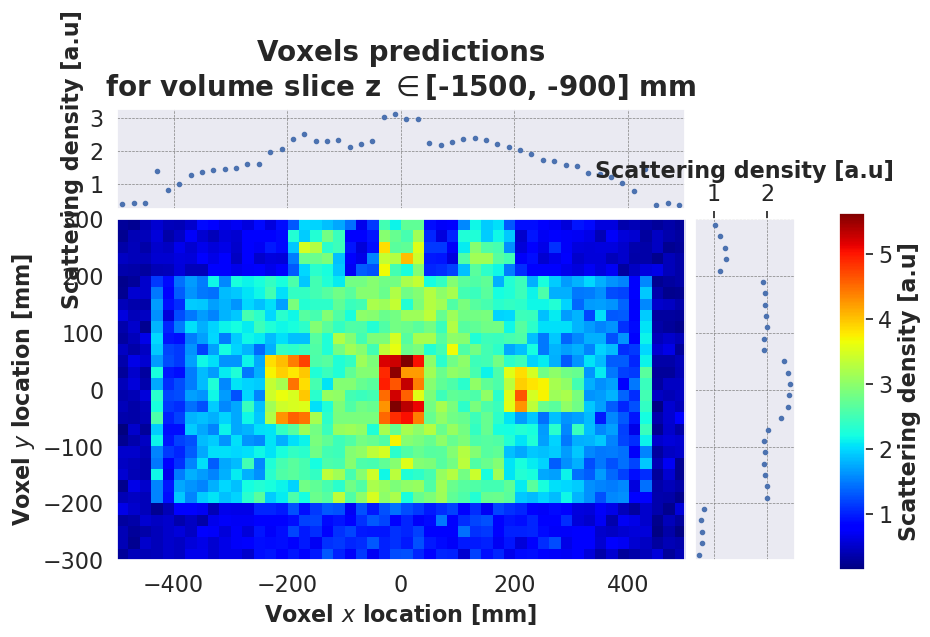

: 

In [ ]:
poca.plot_pred_slice(
    voi=voi,
    xyz_voxel_preds=poca.n_poca_per_vox,
    dim=2,
    voi_slice=(0, poca.voi.n_vox_xyz[2] - 1),
)

## `Tracking_EM` instantiation

The `Tracking_EM` class takes the following **arguments**:

- `voi ([Volume])`: Instance of the Volume class.

- `poca_data ([POCA])`: Instance of the `POCA` class containing tracks and poca points information.

- `poca ([bool])`: Boolean to be set to `True` if the PoCA method is used for the computation of the geometries of muon interaction inside the volume.

- `n_events ([int])`: Number of muon events to be used for `EM`.

- `batch_size ([int])`: Batch size used for batch processing of events.

In [ ]:
%%prun
from muograph.tracking.tracking_em import Tracking_EM
em_tracks = Tracking_EM(voi,poca_data=poca, n_events = 5000, poca=True, batch_size=500)

Finding triggered voxels in batches.


Finding triggered voxels in batches.


Computing alpha vals in batches.
Computing alpha vals in batches.
Computing voxels and muon trajectories intersection coordinates.
Computing voxels and muon trajectories intersection coordinates.


The `plot_EM_tracks` function is used to plot event tracks inside the volume, i.e. the outputs of the `Tracking_EM` class.
It plots two tracks, one connectoing the entry point of the muon to its PoCA location, and the other connecting the POCA to the exit point in the volume.
The triggered voxels along both tracks are plotted as well.

The `plot_EM_tracks` function takes the following **arguments**:

- `voi ([Volume])`: Instance of the Volume class.

- `em_tracks ([Tracking_EM])`: Instance of the `Teacking_EM` class containing geometry and weight information of muon-voxel interaction in the `Volume` instance.

- `event ([int])`: The event whose track information is to be plotted 

- `poca ([bool])`: Boolean to be set to `True` if the PoCA method is used for the instantiation of the `Tracking_EM` class.

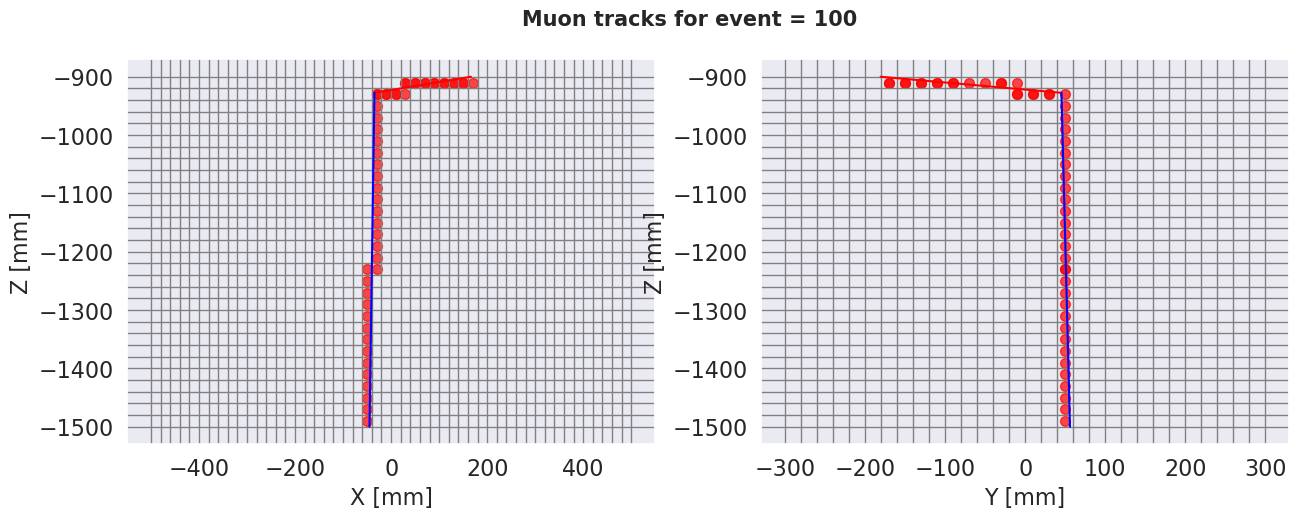

: 

In [ ]:
from muograph.plotting.EM_plotting import plot_EM_tracks
plot_EM_tracks(voi, event=100, tracking=em_tracks, poca = True)

## `EM` reconstruction

The `EM` class takes the following **arguments**:

- `voi ([Volume])`: Instance of the Volume class.

- `em_tracks ([Tracking_EM])`: Instance of the `Teacking_EM` class containing geometry and weight information of muon-voxel interaction in the `Volume` instance.

- `em_iter ([int])`: Number of iterations of the `EM` algorithm. 

- `init_lrad ([float])`: Initial X0 value to be assigned to all voxels of the volume.

In [ ]:
from muograph.reconstruction.em import EM

em_reconstruction=EM(voi, em_tracks, em_iter=100, init_lrad=0.1)

Performing the Expectation and Maximization (EM) steps in batches.


In [ ]:
itermax=em_reconstruct_slr.em_iter-1
reconstr=em_reconstruct_slr
pred = np.log(reconstr.rad_length[99])
#pred=reconstr.scattering_density[99]

em_reconstruction.plot_pred_slice(
    voi=voi,
    xyz_voxel_preds=pred,
    dim=2,
    voi_slice=(0, reconstr.voi.n_vox_xyz[2] - 1),
)